In [1]:
from dgl.data import citation_graph as citegrh
import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
import networkx as nx
import numpy as np
import itertools

In [2]:
from dgl.data import binary_sub_graph as bsg

data = citegrh.load_cora()

trainingset = bsg.CORABinary(DGLGraph(data.graph), data.features, data.labels, num_classes=7)

num_train = len(trainingset)
print("num_train is", num_train)

Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000


/data/huangqi/dgl2/dgl/python/dgl/graph.py:657: UserWarning: to_networkx currently does not support converting node/edge features automatically.
  dgl_warning('to_networkx currently does not support converting'


<class 'dgl.subgraph.DGLSubGraph'>
<class 'dgl.subgraph.DGLSubGraph'>
<class 'dgl.subgraph.DGLSubGraph'>
<class 'dgl.subgraph.DGLSubGraph'>
<class 'dgl.subgraph.DGLSubGraph'>
<class 'dgl.subgraph.DGLSubGraph'>
<class 'dgl.subgraph.DGLSubGraph'>
<class 'dgl.subgraph.DGLSubGraph'>
<class 'dgl.subgraph.DGLSubGraph'>
<class 'dgl.subgraph.DGLSubGraph'>
<class 'dgl.subgraph.DGLSubGraph'>
<class 'dgl.subgraph.DGLSubGraph'>
<class 'dgl.subgraph.DGLSubGraph'>
<class 'dgl.subgraph.DGLSubGraph'>
<class 'dgl.subgraph.DGLSubGraph'>
<class 'dgl.subgraph.DGLSubGraph'>
<class 'dgl.subgraph.DGLSubGraph'>


KeyboardInterrupt: 

In [238]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
n_batch_size = 1
split = 20

indices = list(range(num_train))
training_loader = DataLoader(trainingset, 
                             n_batch_size,
                             collate_fn=testset.collate_fn, 
                             drop_last=True)

In [239]:
# We first validate that in CORA, intra community connections
# are more than inter community connections

g_nx = g.to_networkx(g)
adj = nx.adjacency_matrix(g_nx).todense()
class_to_intra_prob = {i: 0 for i in range(7)}
class_to_total = {i: 0 for i in range(7)}
class_to_intra_sum = {i: 0 for i in range(7)}
for i in range(g_nx.number_of_nodes()):
    _, index = np.where(adj[i] !=0)
    each_total = len(index)
    intra_num = 0
    for j in index:
        if labels[i] == labels[j]:
            intra_num += 1
    class_to_total[int(labels[i])] += each_total
    class_to_intra_sum[int(labels[i])] += intra_num
for i in range(7):
    class_to_intra_prob[i] = class_to_intra_sum[i] / class_to_total[i]
        
    
    
    
    
print(class_to_intra_prob)

{0: 0.07547169811320754, 1: 0.02857142857142857, 2: 0.14521452145214522, 3: 0.32068965517241377, 4: 0.1895424836601307, 5: 0.09917355371900827, 6: 0.11594202898550725}


/data/huangqi/dgl2/dgl/python/dgl/graph.py:657: UserWarning: to_networkx currently does not support converting node/edge features automatically.
  dgl_warning('to_networkx currently does not support converting'


In [240]:
import matplotlib.pyplot as plt
%matplotlib inline
#CORA visualization tool
def cora_viz(labels,subgraph):
    value = [labels[node] for node in subgraph.nodes()]
    pos = nx.spring_layout(subgraph, random_state=1)
    nx.draw_networkx(subgraph, 
                     pos=pos, 
                     edge_color='k', 
                     node_size=5, 
                     cmap=plt.get_cmap('Set2'), 
                     node_color=value,
                     arrows=False,
                     width=0.6,
                     with_labels=False)   

In [241]:
# --------------------Model--------------------------------
class GNNModule(nn.Module):
    def __init__(self, in_feats, in_y_feats, out_feats, radius):
        super().__init__()
        self.out_feats = out_feats
        self.radius = radius

        new_linear = lambda: nn.Linear(in_feats, out_feats)
        new_linear_list = lambda: nn.ModuleList([new_linear() for i in range(radius)])
        
        new_linear_y = lambda: nn.Linear(in_y_feats, out_feats)
        new_linear_list_y = lambda: nn.ModuleList([new_linear_y() for i in range(radius)])
        self.theta_x, self.theta_deg = \
            new_linear(), new_linear()
        self.theta_y = new_linear_y()
        self.theta_list = new_linear_list()

        self.gamma_deg, self.gamma_x = \
            new_linear(), new_linear()
        self.gamma_y = new_linear_y()
        self.gamma_list = new_linear_list_y()

        self.bn_x = nn.BatchNorm1d(out_feats)
        self.bn_y = nn.BatchNorm1d(out_feats)

    def aggregate(self, g, z):
        z_list = []
        g.ndata['z'] = z 
        g.update_all(fn.copy_src(src='z', out='m'), fn.sum(msg='m', out='z'))
        z_list.append(g.ndata['z'])
        for i in range(self.radius - 1):
            for j in range(2 ** i):
                g.update_all(fn.copy_src(src='z', out='m'), fn.sum(msg='m', out='z'))
            z_list.append(g.ndata['z'])
        return z_list

    def forward(self, g, lg, x, y, deg_g, deg_lg, pm_pd):
        pmpd_x = F.embedding(pm_pd, x)

        sum_x = sum(theta(z) for theta, z in zip(self.theta_list, self.aggregate(g, x)))
        
        g.edata['y'] = y
        g.update_all(fn.copy_edge(edge='y', out='m'), fn.sum('m', 'pmpd_y'))
        pmpd_y = g.pop_n_repr('pmpd_y')

        x = self.theta_x(x) + self.theta_deg(deg_g * x) + sum_x + self.theta_y(pmpd_y)
        n = self.out_feats // 2
        x = th.cat([x[:, :n], F.relu(x[:, n:])], 1)
        x = self.bn_x(x)

        sum_y = sum(gamma(z) for gamma, z in zip(self.gamma_list, self.aggregate(lg, y)))
        y = self.gamma_y(y)
        
        y = th.cat([y[:, :n], F.relu(y[:, n:])], 1)
        y = self.bn_y(y)

        return x, y

class GNN(nn.Module):
    def __init__(self, feats, radius, n_classes):
        """
        Parameters
        ----------
        g : networkx.DiGraph
        """
        super(GNN, self).__init__()
        self.linear = nn.Linear(feats[-1], n_classes)
        self.y_feats = [1] + feats[1:]
        self.module_list = nn.ModuleList([GNNModule(m, m_y, n, radius)
                                          for m, m_y, n in zip(feats[:-1],self.y_feats[:-1], feats[1:])])

    def forward(self, g, lg, deg_g, deg_lg, pm_pd, feature):
        x, y = feature, deg_lg
        for module in self.module_list:
            x, y = module(g, lg, x, y, deg_g, deg_lg, pm_pd)
        return self.linear(x)

In [242]:
def accuracy(z_list, labels):
    accu = []
    ybar_list = [th.max(z, 1)[1] for z in z_list]
    for y_bar in ybar_list:
        accuracy = max(th.sum(y_bar == label).item() for label in labels) / len(labels[0])
        accu.append(accuracy)
    return sum(accu) / len(accu)



In [243]:
import time
def step(i, j, g, lg, deg_g, deg_lg, pm_pd, feature, label, equi_label, n_batchsize):
    """ One step of training. """
    t0 = time.time()
    z = model(g, lg, deg_g, deg_lg, pm_pd, feature)
    time_forward = time.time() - t0

    z_list = th.chunk(z, n_batchsize, 0)
    equi_labels = [label, equi_label]
    loss = sum(min(F.cross_entropy(z, y) for y in equi_labels) for z in z_list) / n_batchsize
    
    accu = accuracy(z_list, equi_labels)

    optimizer.zero_grad()
    t0 = time.time()
    loss.backward()
    time_backward = time.time() - t0
    optimizer.step()

    return loss, accu, time_forward, time_backward

In [244]:
def val(g, lg, deg_g, deg_lg, pm_pd, feature, label, equi_label):
    z = model(g, lg, deg_g, deg_lg, pm_pd, feature)
    
    z_list = [z]
    
    equi_labels = [label, equi_label]
    
    accu = accuracy(z_list, equi_labels)
    
    return accu

In [245]:
def inference_viz(g, lg, deg_g, deg_lg, pm_pd, feature):
    z = model(g, lg, deg_g, deg_lg, pm_pd, feature)
    
    z_list = [z]
    
    n_batchsize = 1
    ybar_list = [th.max(z, 1)[1] for z in z_list]
    cora_viz(ybar_list[0],g.to_networkx())

In [246]:
import torch.optim as optim
n_features = 16
n_layers = 2
radius = 1
lr = 1e-2
K = 2 # num_of_classes
inference_idx = 8
feats = [features.shape[1]] + [n_features]*n_layers + [K]
model = GNN(feats, radius, K)

optimizer = optim.Adam(model.parameters(), lr=lr)

average loss for epoch 0 is 0.6508466005325317, with avg accu 0.6544349792773697, forward time 2.471755266189575, backward time 0.7471661567687988
average loss for epoch 1 is 0.6432218551635742, with avg accu 0.6564926246946543, forward time 2.7958483695983887, backward time 1.1669127941131592
average loss for epoch 2 is 0.6436918377876282, with avg accu 0.6565613015514614, forward time 2.637753486633301, backward time 1.0349302291870117
average loss for epoch 3 is 0.6436415314674377, with avg accu 0.6566071331661092, forward time 2.6319804191589355, backward time 0.945314884185791
average loss for epoch 4 is 0.6434112191200256, with avg accu 0.6565613015514614, forward time 2.9734280109405518, backward time 0.9893903732299805
average loss for epoch 5 is 0.643007218837738, with avg accu 0.6567410714057118, forward time 2.6489217281341553, backward time 0.9427528381347656
average loss for epoch 6 is 0.6438060998916626, with avg accu 0.6570170380776981, forward time 2.2614803314208984, b

/data/huangqi/dgl2/dgl/python/dgl/graph.py:657: UserWarning: to_networkx currently does not support converting node/edge features automatically.
  dgl_warning('to_networkx currently does not support converting'


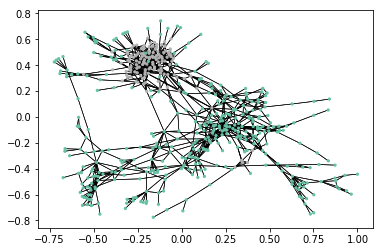

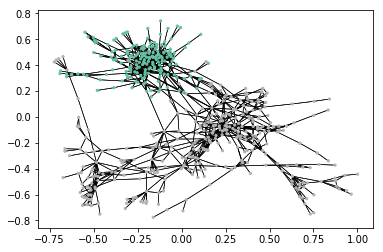

In [247]:
#main loop



n_iterations = 20
n_epochs = 10
validation_example_label_change = []
total_time = 0
for i in range(n_epochs):
    total_loss, total_accu, s_forward, s_backward = 0, 0, 0, 0
    for j, [g, lg, g_deg, lg_deg, pm_pd, subfeature, label, equivariant_label] in enumerate(training_loader):
        loss, accu, t_forward, t_backward = step(i,
                                                 j,
                                                 g,
                                                 lg,
                                                 th.FloatTensor(g_deg),
                                                 th.FloatTensor(lg_deg),
                                                 th.LongTensor(pm_pd),
                                                 th.FloatTensor(subfeature),
                                                 th.LongTensor(label),
                                                 th.LongTensor(equivariant_label),
                                                 n_batch_size)
        total_loss += loss
        s_forward += t_forward
        s_backward += t_backward
        total_accu += accu
    total_time += (s_forward + s_backward)
    
    print("average loss for epoch {} is {}, with avg accu {}, forward time {}, backward time {}".format(i, total_loss/len(training_loader), total_accu/len(training_loader), s_forward, s_backward))
    [g, lg, g_deg, lg_deg, pm_pd, subfeature, label, equi_label] = trainingset[inference_idx]    
    z = model(g,
              lg, 
              th.FloatTensor(g_deg), 
              th.FloatTensor(lg_deg), 
              th.LongTensor(pm_pd), 
              th.FloatTensor(subfeature))
    validation_example_label_change.append(th.max(z, 1)[1])
print("total time {} s, average {}".format(total_time, total_time/n_iterations))
    
    
    
print("inference on one training example...")
for k in range(len(training_loader) - split):
    [g, lg, g_deg, lg_deg, pm_pd, subfeature, label, equi_label] = trainingset[inference_idx]
    accu = val(g, 
               lg, 
               th.FloatTensor(g_deg), 
               th.FloatTensor(lg_deg), 
               th.LongTensor(pm_pd), 
               th.FloatTensor(subfeature),
               th.LongTensor(label),
               th.LongTensor(equi_label))
    print("#########")
    print("inference accu {}".format(accu))
    print("#########")
    inference_viz(g,
                  lg,
                  th.FloatTensor(g_deg),
                  th.FloatTensor(lg_deg),
                  th.LongTensor(pm_pd),
                  th.FloatTensor(subfeature))
    plt.show()
    cora_viz(label, g.to_networkx())
    plt.show()



In [230]:
x = th.ones(3)
y = th.ones(4)
th.cat([x, y])

tensor([1., 1., 1., 1., 1., 1., 1.])

In [231]:
import matplotlib.animation as animation
%matplotlib notebook

In [232]:
def cora_viz_ani(labels,subgraph):
    value = [labels[node] for node in subgraph.nodes()]
    pos = nx.spring_layout(subgraph, random_state=1)
    nx.draw_networkx(subgraph, 
                     pos=pos, 
                     edge_color='k', 
                     node_size=5, 
                     cmap=plt.get_cmap('Set2'), 
                     node_color=value,
                     with_labels=False)   

<IPython.core.display.Javascript object>


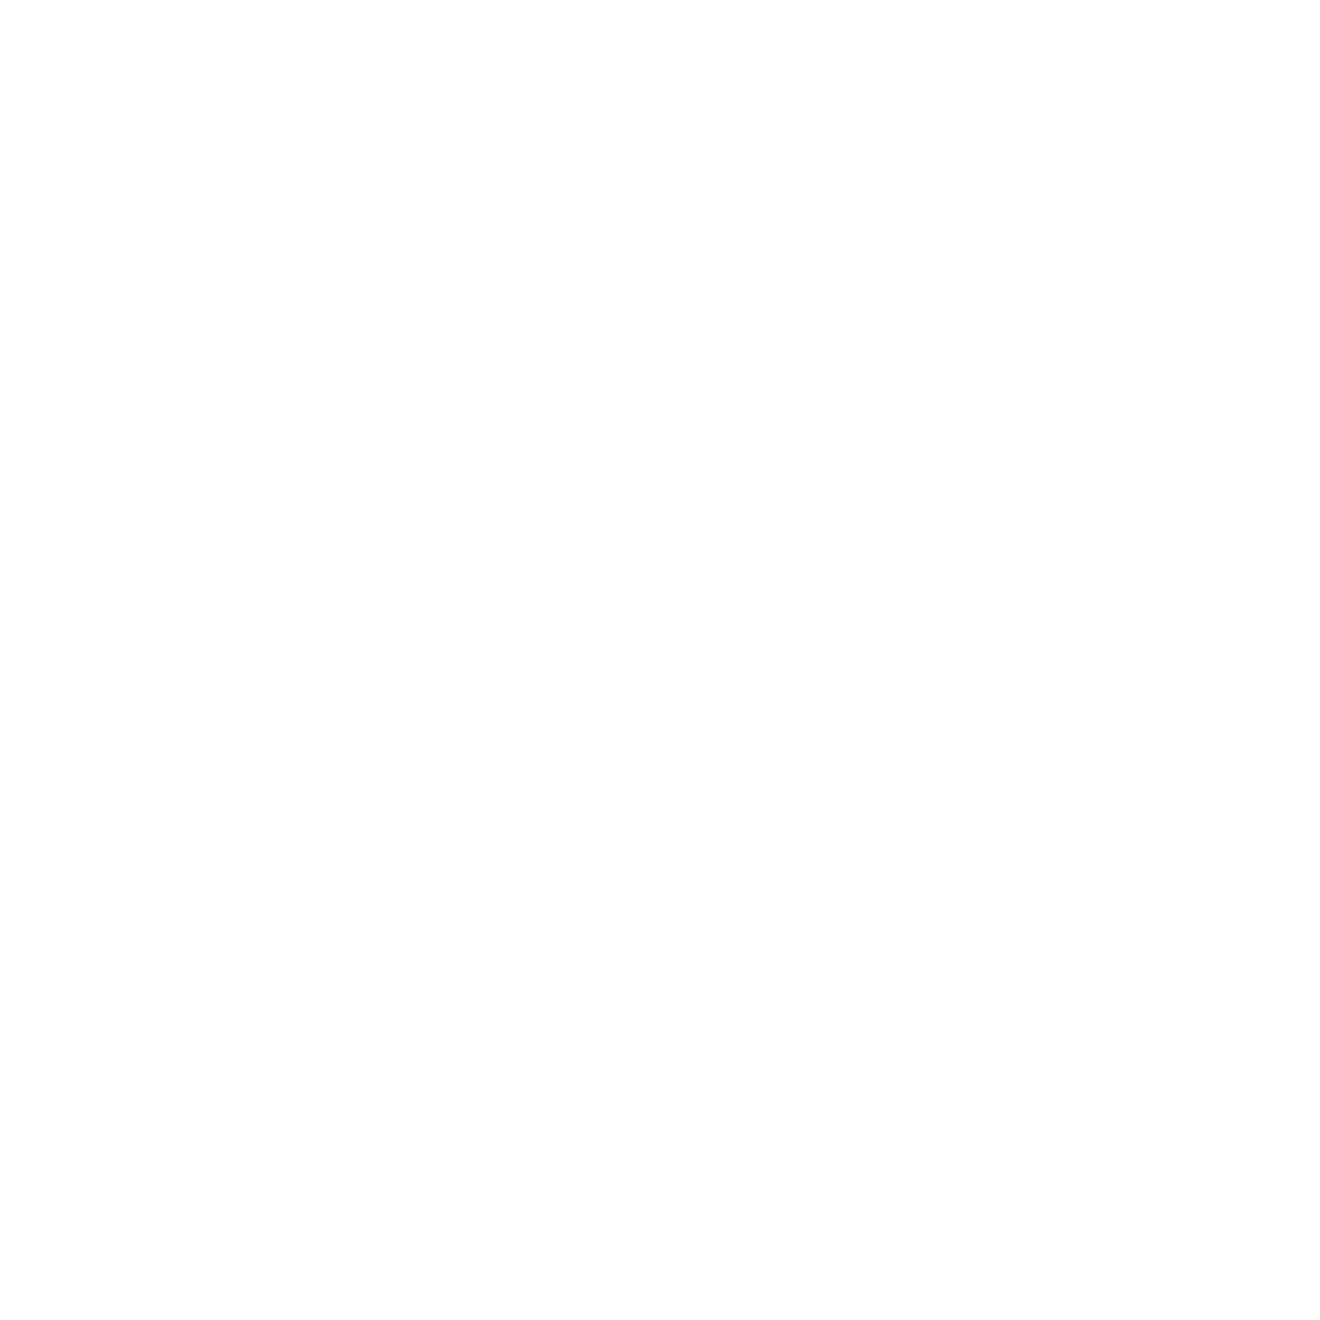

/data/huangqi/dgl2/dgl/python/dgl/graph.py:657: UserWarning: to_networkx currently does not support converting node/edge features automatically.
  dgl_warning('to_networkx currently does not support converting'


<IPython.core.display.Javascript object>


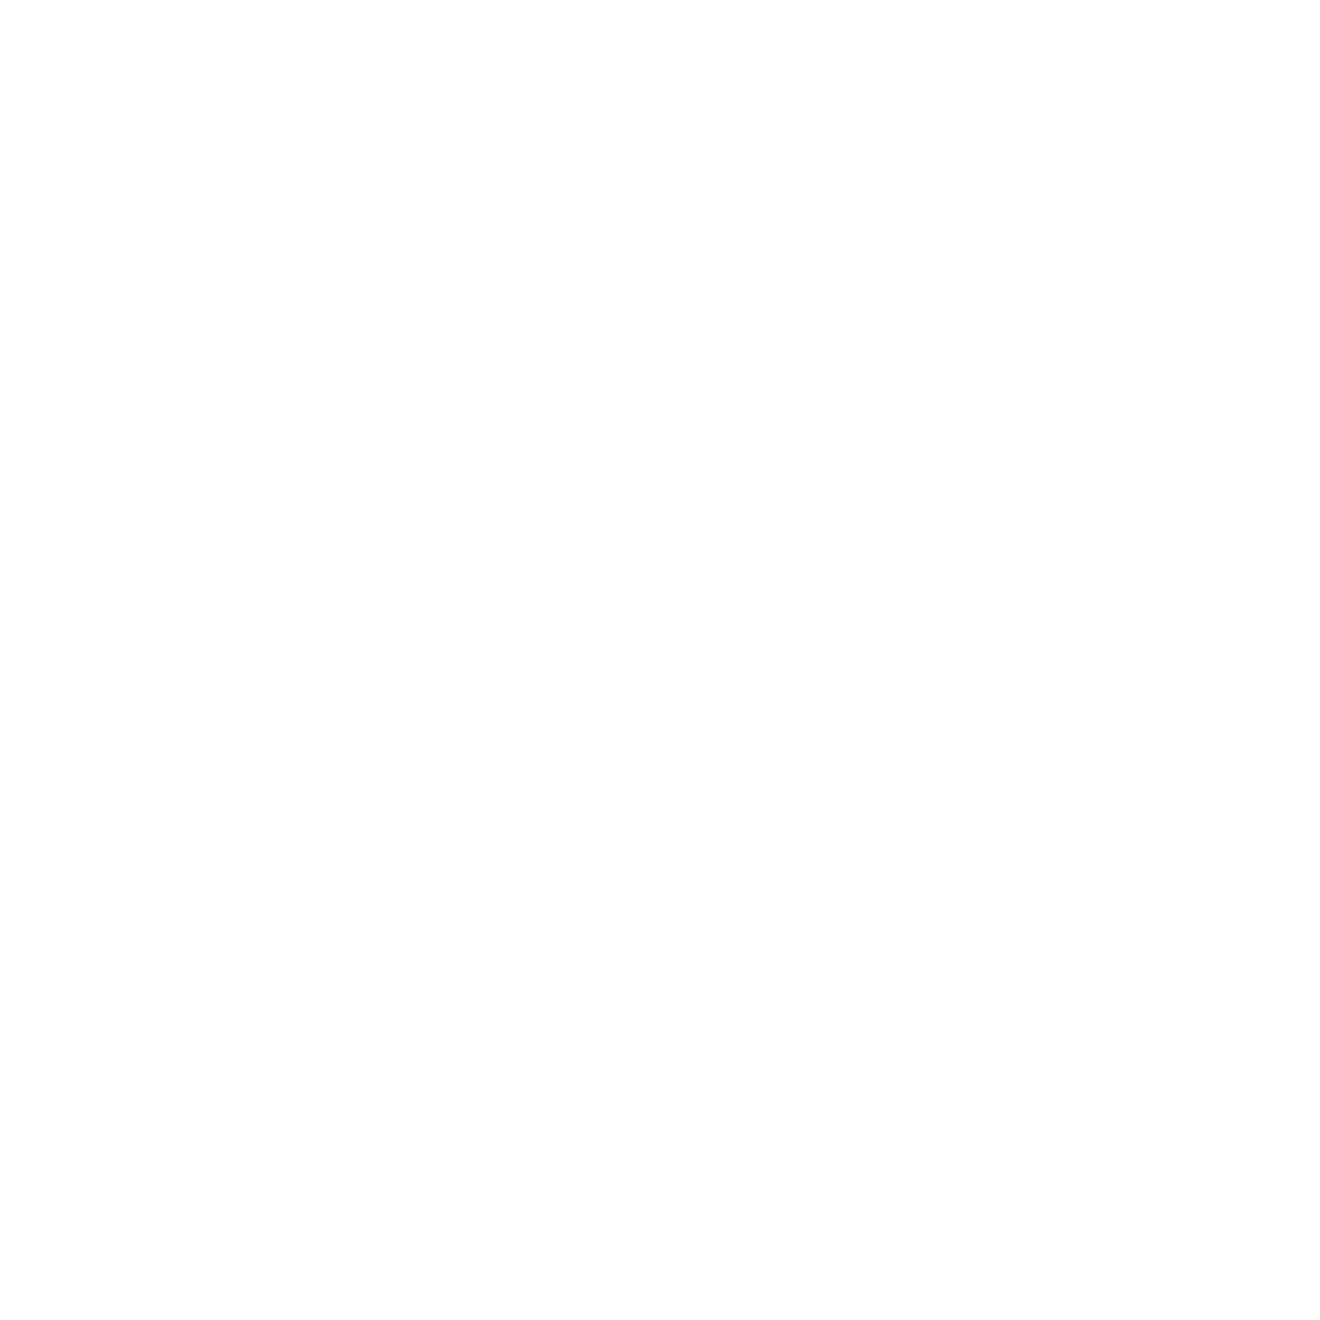

Traceback (most recent call last):
  File "/data/huangqi/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 388, in process
    proxy(*args, **kwargs)
  File "/data/huangqi/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 228, in __call__
    return mtd(*args, **kwargs)
  File "/data/huangqi/anaconda3/lib/python3.6/site-packages/matplotlib/animation.py", line 1499, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


In [233]:
fig2 = plt.figure(figsize=(8,8), dpi=150)
fig2.clf()
ax = fig2.subplots()
[g, lg, g_deg, lg_deg, pm_pd, subfeature, label, equi_label] = trainingset[inference_idx]
g_nx = g.to_networkx()
pos = nx.spring_layout(g_nx, random_state=1)

def classify_animate(i):
    ax.cla()
    ax.axis('off')
    ax.set_title("community detection result @ epoch %d" % i)
    value = [validation_example_label_change[i][node] for node in g_nx.nodes()]
    nx.draw_networkx(g_nx,
                     pos=pos,
                     edge_color='k',
                     node_size=7,
                     cmap=plt.get_cmap('Set2'),
                     node_color=value,
                     arrows=False,
                     width=0.6,
                     with_labels=False)
    

ani = animation.FuncAnimation(fig2, classify_animate, frames=len(validation_example_label_change), interval=500)
ani.save('./animationnew.gif', writer='imagemagick')
plt.show()

/data/huangqi/dgl2/dgl/python/dgl/graph.py:657: UserWarning: to_networkx currently does not support converting node/edge features automatically.
  dgl_warning('to_networkx currently does not support converting'


<IPython.core.display.Javascript object>


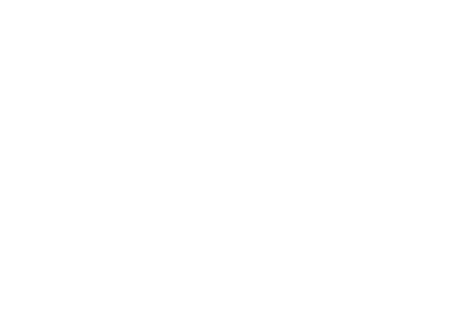

<IPython.core.display.Javascript object>


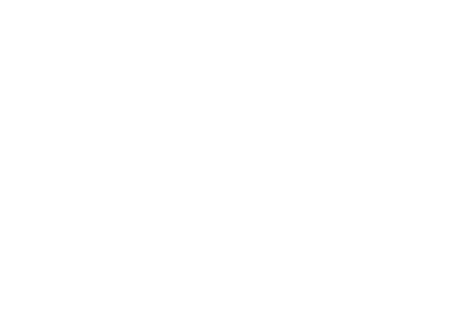

In [234]:
toygraph = DGLGraph()
toygraph.add_nodes(4)
toygraph.add_edges([0,1,1,0,3,3,2],[1,0,2,3,2,0,0])
nx.draw(toygraph.to_networkx(), with_labels=True)
lg = toygraph.line_graph(backtracking=False)


/data/huangqi/dgl2/dgl/python/dgl/graph.py:657: UserWarning: to_networkx currently does not support converting node/edge features automatically.
  dgl_warning('to_networkx currently does not support converting'


<IPython.core.display.Javascript object>


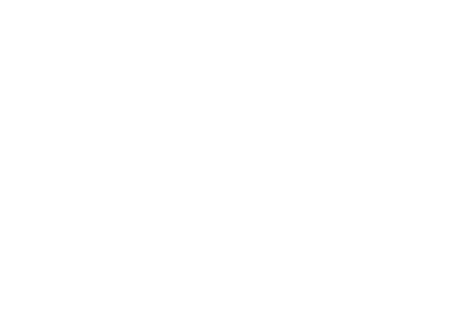

<IPython.core.display.Javascript object>


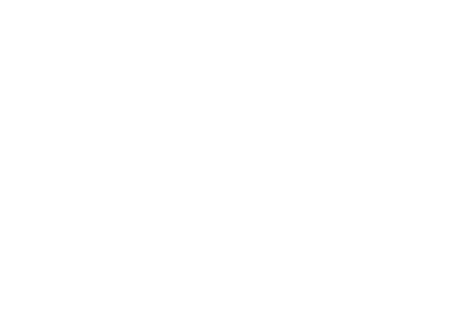

In [235]:
nx.draw(lg.to_networkx(), with_labels=True)